<a href="https://colab.research.google.com/github/alessioborgi/RL_Project/blob/main/X_GNN_MUTAG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# X-GNN: Model-Explanations of GNNs using RL

### *Alessio Borgi*
### *Francesco Danese*

### 0: INSTALLING & IMPORTING LIBRARIES

In [1]:
!pip install torch_geometric networkx matplotlib

In [2]:
import os
import torch
import random
import numpy as np
import pandas as pd
import torch.nn as nn
import networkx as nx
from torch.nn import Linear
import plotly.express as px
import matplotlib.pyplot as plt
import torch.nn.functional as F
import plotly.graph_objects as go
from torch_geometric.nn import MessagePassing
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_networkx

In [3]:
'''# Ensures that dataset splitting, model initialization, and training are deterministic.
def set_seed(seed):
    torch.manual_seed(seed)  # Fix seed for PyTorch (CPU).
    torch.cuda.manual_seed(seed)  # Fix seed for PyTorch (GPU).
    torch.cuda.manual_seed_all(seed)  # Fix seed for all GPUs.
    np.random.seed(seed)  # Fix seed for NumPy.
    random.seed(seed)  # Fix seed for Python's random module.
    torch.backends.cudnn.deterministic = True  # Ensure deterministic GPU behavior.
    torch.backends.cudnn.benchmark = False  # Disable cuDNN auto-tuning to enforce determinism.

set_seed(42)  # Set seed to ensure reproducibility across runs.
'''

"# Ensures that dataset splitting, model initialization, and training are deterministic.\ndef set_seed(seed):\n    torch.manual_seed(seed)  # Fix seed for PyTorch (CPU).\n    torch.cuda.manual_seed(seed)  # Fix seed for PyTorch (GPU).\n    torch.cuda.manual_seed_all(seed)  # Fix seed for all GPUs.\n    np.random.seed(seed)  # Fix seed for NumPy.\n    random.seed(seed)  # Fix seed for Python's random module.\n    torch.backends.cudnn.deterministic = True  # Ensure deterministic GPU behavior.\n    torch.backends.cudnn.benchmark = False  # Disable cuDNN auto-tuning to enforce determinism.\n\nset_seed(42)  # Set seed to ensure reproducibility across runs.\n"

### 1: DATASET EXPLORATION

In [5]:
from torch_geometric.datasets import TUDataset
# Load the MUTAG Dataset
dataset = TUDataset(root='data/TUDataset', name='MUTAG')

In [6]:
import random
import pandas as pd
from torch_geometric.datasets import TUDataset

# Load the MUTAG Dataset.
dataset = TUDataset(root='data/TUDataset', name='MUTAG')

# Initialize lists to collect dataset-wide statistics.
num_nodes = []
num_edges = []
labels = []

dataset_indices = list(range(len(dataset)))

# Gather data about all graphs.
for data in dataset:
    num_nodes.append(data.num_nodes)
    num_edges.append(data.num_edges)
    labels.append(data.y.item())

# Create a summary DataFrame.
df = pd.DataFrame({
    "Graph ID": dataset_indices,
    "Num Nodes": num_nodes,
    "Num Edges": num_edges,
    "Label": labels
})

# Dataset Statistics.
print()
print(f'Dataset: {dataset}:')
print('====================')
print(f"Number of Graphs: {len(dataset)}")
print(f"Number of Classes: {dataset.num_classes}")
print(f"Average Nodes per Graph: {sum(num_nodes)/len(num_nodes):.2f}")
print(f"Average Edges per Graph: {sum(num_edges)/len(num_edges):.2f}")
print("Class Distribution:")
print(df['Label'].value_counts())

'''
# Separate the indices for each class.
class_0_indices = df[df['Label'] == 0]['Graph ID'].tolist()
class_1_indices = df[df['Label'] == 1]['Graph ID'].tolist()

# Downsample class 1 to match class 0.
random.seed(42)  # For reproducibility
balanced_class_1_indices = random.sample(class_1_indices, len(class_0_indices))

# Combine the downsampled class 1 indices with class 0 indices.
balanced_indices = class_0_indices + balanced_class_1_indices

# Update the dataset in place with the balanced indices.
dataset = [dataset[i] for i in balanced_indices]

# Update the DataFrame with the new dataset statistics.
updated_num_nodes = [dataset[i].num_nodes for i in range(len(dataset))]
updated_num_edges = [dataset[i].num_edges for i in range(len(dataset))]
updated_labels = [dataset[i].y.item() for i in range(len(dataset))]

# Create the updated DataFrame.
df = pd.DataFrame({
    "Graph ID": range(len(dataset)),
    "Num Nodes": updated_num_nodes,
    "Num Edges": updated_num_edges,
    "Label": updated_labels
})

# Updated dataset statistics.
print("\nUpdated Dataset Statistics:")
print('============================')
print(f"Number of Graphs: {len(dataset)}")
print("Class Distribution:")
print(df['Label'].value_counts())
'''


Dataset: MUTAG(188):
Number of Graphs: 188
Number of Classes: 2
Average Nodes per Graph: 17.93
Average Edges per Graph: 39.59
Class Distribution:
Label
1    125
0     63
Name: count, dtype: int64


'\n# Separate the indices for each class.\nclass_0_indices = df[df[\'Label\'] == 0][\'Graph ID\'].tolist()\nclass_1_indices = df[df[\'Label\'] == 1][\'Graph ID\'].tolist()\n\n# Downsample class 1 to match class 0.\nrandom.seed(42)  # For reproducibility\nbalanced_class_1_indices = random.sample(class_1_indices, len(class_0_indices))\n\n# Combine the downsampled class 1 indices with class 0 indices.\nbalanced_indices = class_0_indices + balanced_class_1_indices\n\n# Update the dataset in place with the balanced indices.\ndataset = [dataset[i] for i in balanced_indices]\n\n# Update the DataFrame with the new dataset statistics.\nupdated_num_nodes = [dataset[i].num_nodes for i in range(len(dataset))]\nupdated_num_edges = [dataset[i].num_edges for i in range(len(dataset))]\nupdated_labels = [dataset[i].y.item() for i in range(len(dataset))]\n\n# Create the updated DataFrame.\ndf = pd.DataFrame({\n    "Graph ID": range(len(dataset)),\n    "Num Nodes": updated_num_nodes,\n    "Num Edges": up

In [7]:
# Plot class distribution using Plotly.
class_counts = df['Label'].value_counts().reset_index()
class_counts.columns = ['Label', 'Count']

fig = px.bar(
    class_counts,
    x='Label', y='Count',
    labels={"Label": "Class Label", "Count": "Count"},
    title="Class Distribution in MUTAG Dataset"
)
fig.show()


In [8]:
# Take the first graph of the Dataset.
single_graph = dataset[0]
print()
print(single_graph)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {single_graph.num_nodes}')
print(f'Number of edges: {single_graph.num_edges}')
print(f'Average node degree: {single_graph.num_edges / single_graph.num_nodes:.2f}')
print(f'Has isolated nodes: {single_graph.has_isolated_nodes()}')
print(f'Has self-loops: {single_graph.has_self_loops()}')
print(f'Is undirected: {single_graph.is_undirected()}')


Data(edge_index=[2, 38], x=[17, 7], edge_attr=[38, 4], y=[1])
Number of nodes: 17
Number of edges: 38
Average node degree: 2.24
Has isolated nodes: False
Has self-loops: False
Is undirected: True


In [9]:
import torch
import plotly.graph_objs as go
import networkx as nx
from torch_geometric.utils import to_networkx
import matplotlib.pyplot as plt
import numpy as np

# Assuming you already have the graph data loaded as `single_graph`
# Convert the first graph in the dataset to NetworkX.
G = to_networkx(single_graph, to_undirected=True)

# Extract the node feature matrix
node_features = single_graph.x  # Shape: [num_nodes, num_features]

# Convert one-hot encoded node features to atom types (indices)
node_colors = torch.argmax(node_features, dim=1).numpy()

# Define a colormap for different atom types
cmap = plt.get_cmap("tab10")  # You can choose any matplotlib colormap
unique_atom_types = np.unique(node_colors)
colors = {atom_type: cmap(i / len(unique_atom_types)) for i, atom_type in enumerate(unique_atom_types)}

# Generate 2D layout
pos_2d = nx.spring_layout(G, seed=42)

# Prepare edge trace for 2D visualization
edge_x_2d = []
edge_y_2d = []
for edge in G.edges():
    x0, y0 = pos_2d[edge[0]]
    x1, y1 = pos_2d[edge[1]]
    edge_x_2d.extend([x0, x1, None])
    edge_y_2d.extend([y0, y1, None])

edge_trace_2d = go.Scatter(
    x=edge_x_2d, y=edge_y_2d,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines'
)

# Prepare node trace for 2D visualization
node_x_2d = []
node_y_2d = []
node_labels = []
node_colors_plotly = []

for node in G.nodes():
    x, y = pos_2d[node]
    node_x_2d.append(x)
    node_y_2d.append(y)
    atom_type_list = ['C', 'N', 'O', 'F', 'I', 'Cl', 'Br']
    atom_type = atom_type_list[node_colors[node]]
    node_labels.append(f"{atom_type}")
    rgba_color = colors[node_colors[node]]
    plotly_color = f"rgba({rgba_color[0] * 255}, {rgba_color[1] * 255}, {rgba_color[2] * 255}, {rgba_color[3]})"
    node_colors_plotly.append(plotly_color)

node_trace_2d = go.Scatter(
    x=node_x_2d, y=node_y_2d,
    mode='markers+text',
    hoverinfo='text',
    marker=dict(
        size=10,
        color=node_colors_plotly,
    ),
    text=node_labels,
    textposition="top center"
)

# 2D Visualization
fig_2d = go.Figure(data=[edge_trace_2d, node_trace_2d],
                   layout=go.Layout(
                       title="2D Visualization of Graph 0",
                       showlegend=False,
                       hovermode='closest',
                       margin=dict(b=0, l=0, r=0, t=40),
                       xaxis=dict(showgrid=False, zeroline=False),
                       yaxis=dict(showgrid=False, zeroline=False)
                   ))
fig_2d.show()

# Analyze graph properties
print(f"Number of nodes: {single_graph.num_nodes}")
print(f"Number of edges: {single_graph.num_edges}")
print(f"Is graph directed? {single_graph.is_directed()}")
print(f"Graph label: {single_graph.y}")


Number of nodes: 17
Number of edges: 38
Is graph directed? False
Graph label: tensor([1])


In [10]:
import torch
import plotly.graph_objs as go
import networkx as nx
from torch_geometric.utils import to_networkx
import numpy as np
import matplotlib.pyplot as plt

single_graph = dataset[4]
# Assuming you already have the graph data loaded as `single_graph`
# Convert the first graph in the dataset to NetworkX.
G = to_networkx(single_graph, to_undirected=True)

# Extract the node feature matrix
node_features = single_graph.x  # Shape: [num_nodes, num_features]

# Convert one-hot encoded node features to atom types (indices)
node_colors = torch.argmax(node_features, dim=1).numpy()

# Define atom labels and fixed colormap
atom_labels = ['C', 'N', 'O', 'F', 'I', 'Cl', 'Br']
fixed_colors = {
    'C': 'rgba(0, 255, 0, 1)',  # Green
    'N': 'rgba(255, 0, 0, 1)',  # Red
    'O': 'rgba(0, 0, 255, 1)',  # Blue
    'F': 'rgba(255, 255, 0, 1)',  # Yellow
    'I': 'rgba(128, 0, 128, 1)',  # Purple
    'Cl': 'rgba(255, 165, 0, 1)',  # Orange
    'Br': 'rgba(75, 0, 130, 1)'   # Indigo
}

# Generate 3D layout
pos_3d = nx.spring_layout(G, dim=3, seed=42)

# Extract node labels based on atom types
node_labels = []
node_colors_plotly = []
for node in G.nodes():
    atom_type = atom_labels[node_colors[node]]
    node_labels.append(atom_type)
    plotly_color = fixed_colors[atom_type]
    node_colors_plotly.append(plotly_color)

# Prepare edge trace for 3D visualization
edge_x_3d = []
edge_y_3d = []
edge_z_3d = []
for edge in G.edges():
    x0, y0, z0 = pos_3d[edge[0]]
    x1, y1, z1 = pos_3d[edge[1]]
    edge_x_3d.extend([x0, x1, None])
    edge_y_3d.extend([y0, y1, None])
    edge_z_3d.extend([z0, z1, None])

edge_trace_3d = go.Scatter3d(
    x=edge_x_3d, y=edge_y_3d, z=edge_z_3d,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines'
)

# Prepare node trace for 3D visualization
node_x_3d = []
node_y_3d = []
node_z_3d = []
for node in G.nodes():
    x, y, z = pos_3d[node]
    node_x_3d.append(x)
    node_y_3d.append(y)
    node_z_3d.append(z)

node_trace_3d = go.Scatter3d(
    x=node_x_3d, y=node_y_3d, z=node_z_3d,
    mode='markers+text',
    hoverinfo='text',
    marker=dict(
        size=10,
        color=node_colors_plotly,
    ),
    text=node_labels,
    textposition="top center"
)

# 3D Visualization
fig_3d = go.Figure(data=[edge_trace_3d, node_trace_3d],
                   layout=go.Layout(
                       title="3D Visualization of Graph 0",
                       showlegend=False,
                       margin=dict(b=0, l=0, r=0, t=40),
                       scene=dict(
                           xaxis=dict(showticklabels=False),
                           yaxis=dict(showticklabels=False),
                           zaxis=dict(showticklabels=False)
                       )
                   ))
fig_3d.show()

# Analyze graph properties
print(f"Number of nodes: {single_graph.num_nodes}")
print(f"Number of edges: {single_graph.num_edges}")
print(f"Is graph directed? {single_graph.is_directed()}")
print(f"Graph label: {single_graph.y}")


Number of nodes: 11
Number of edges: 22
Is graph directed? False
Graph label: tensor([0])


In [11]:
i = 0
for d in dataset:
  if d.x[:, 4].sum().item() > 0:
    print(i)
  i+=1

21


### GNN MODEL

In [12]:
import random
import copy
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch_geometric.nn import GCNConv, global_mean_pool

class GCN(torch.nn.Module):
    def __init__(self, node_feature_dim: int, num_class: int, dropout: float = 0.1):
        super(GCN, self).__init__()
        self.gc1 = GCNConv(node_feature_dim, 32, add_self_loops=True, normalize=True)
        self.gc2 = GCNConv(32, 48, add_self_loops=True, normalize=True)
        self.gc3 = GCNConv(48, 64, add_self_loops=True, normalize=True)

        # Final classifier containing two fully connected layers
        self.fc1 = torch.nn.Linear(64, 32)
        self.fc2 = torch.nn.Linear(32, num_class)
        self.dropout = dropout

    def forward(self, x, edge_index, batch=None):
        x = F.relu(self.gc1(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.relu(self.gc2(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.relu(self.gc3(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)

        # If batch is provided, do global mean pooling, else pool all nodes (single graph)
        if batch is not None:
            x = global_mean_pool(x, batch)
        else:
            x = x.mean(dim=0, keepdim=True)

        # Final classification
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [19]:
# Training loop for MUTAG dataset
from torch.optim import Adam

def train_gcn(dataset, lr, batch_size, epochs):
    # Load MUTAG dataset
    train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Initialize the model, optimizer, and loss function
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = GCN(node_feature_dim=dataset.num_features, num_class=dataset.num_classes).to(device)
    optimizer = Adam(model.parameters(), lr=lr, weight_decay=5e-4)

    # Training process
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for data in train_loader:
            data = data.to(device)
            optimizer.zero_grad()
            out = model(data.x, data.edge_index, data.batch)
            loss = F.cross_entropy(out, data.y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * data.num_graphs
        if epoch % 100 == 0:
           print(f'Epoch {epoch + 1}, Loss: {total_loss / len(dataset):.4f}')

    # Testing process
    model.eval()
    correct = 0
    for data in train_loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch)
        pred = out.argmax(dim=1)
        correct += (pred == data.y).sum().item()
    accuracy = correct / len(dataset)
    print(f'Training Set Accuracy: {accuracy:.4f}')
    torch.save(model.state_dict(), './gcn_first.pth')

if __name__ == "__main__":
    train_gcn(dataset, lr = 0.001, batch_size = 32, epochs = 1000)

Epoch 1, Loss: 0.6984
Epoch 101, Loss: 0.4863
Epoch 201, Loss: 0.4745
Epoch 301, Loss: 0.4612
Epoch 401, Loss: 0.4466
Epoch 501, Loss: 0.4413
Epoch 601, Loss: 0.4157
Epoch 701, Loss: 0.4062
Epoch 801, Loss: 0.3752
Epoch 901, Loss: 0.3847
Training Set Accuracy: 0.8777


### GRAPH GENERATOR

In [100]:

class Generator(nn.Module):
    def __init__(self, model_path: str, C: list, num_class=2, c=0, max_nodes=5, hyp1=1, hyp2=2, start=None, nfeat=7, dropout=0.1):
        """
        :param C: Candidate set of nodes (list)
        :param start: Starting node (defaults to randomized node)
        """
        super(Generator, self).__init__()
        self.num_class = num_class
        self.max_nodes = max_nodes
        self.dropout = dropout
        self.c = c  # c is the specific class of graph to be generated

        self.fc = nn.Linear(nfeat, 8)
        self.gc1 = GCNConv(8, 16, add_self_loops=True, normalize=True)
        self.gc2 = GCNConv(16, 24, add_self_loops=True, normalize=True)
        self.gc3 = GCNConv(24, 32, add_self_loops=True, normalize=True)

        # MLP1 - 2 FC layers with hidden dimension 16
        self.mlp1 = nn.Sequential(nn.Linear(32, 16), nn.Linear(16, 1))

        # MLP2 - 2 FC layers with hidden dimension 24
        self.mlp2 = nn.Sequential(nn.Linear(64, 24), nn.Linear(24, 1))

        # Hyperparameters
        self.hyp1 = hyp1
        self.hyp2 = hyp2
        self.candidate_set = C

        # Default starting node (if any)
        if start is not None:
            self.start = start
            self.random_start = False
        else:
            self.start = random.choice(np.arange(0, len(self.candidate_set)))
            self.random_start = True

        # Load GCN for calculating reward (placeholder GCN, replace with your actual model)
        self.model = GCN(node_feature_dim=nfeat, num_class=num_class, dropout=dropout)
        self.model.load_state_dict(torch.load(model_path))
        for param in self.model.parameters():
            param.requires_grad = False

        self.reset_graph()

    def reset_graph(self):
        """
        Reset g.G to default graph with only the start node.
        """
        if self.random_start:
            self.start = random.choice(np.arange(0, len(self.candidate_set)))

        # Create feature matrix with a single starting node
        feat = torch.zeros((1, len(self.candidate_set)), dtype=torch.float32)
        feat[0, self.start] = 1  # One-hot encoding for the starting node

        # Start with an empty edge index (self-loops will be added automatically by GCN layers)
        edge_index = torch.empty((2, 0), dtype=torch.long)

        degrees = torch.tensor([0]) # the degree of each node in the graph, at the start only 1 node with no edges so "0"

        self.G = {'feat': feat, 'edge_index': edge_index, 'num_nodes': 1, 'degrees': degrees}

    ## Calculate Gt -> Gt+1
    def forward(self, G_in):
        ## G_in is Gt
        G = copy.deepcopy(G_in)

        # Expand feature matrix to include candidate nodes
        candidate_feats = torch.eye(len(self.candidate_set), dtype=torch.float32)
        x = torch.cat((G['feat'], candidate_feats), dim=0)

        # No need to manually add self-loops for candidate nodes or others
        edge_index = G['edge_index']

        ## Corresponds to X = GCNs(Gt, C)
        x = F.relu6(self.fc(x))
        x = F.dropout(x, self.dropout, training=self.training)
        x = F.relu6(self.gc1(x, edge_index))
        x = F.dropout(x, self.dropout, training=self.training)
        x = F.relu6(self.gc2(x, edge_index))
        x = F.dropout(x, self.dropout, training=self.training)
        x = F.relu6(self.gc3(x, edge_index))
        x = F.dropout(x, self.dropout, training=self.training)

        ## pt,start = Softmax(MLPs(X))
        p_start = self.mlp1(x)
        p_start = F.log_softmax(p_start, dim=0)

        # Create mask_start - only candidate nodes are masked, original nodes are unmasked
        mask_start = torch.BoolTensor([False] * G['num_nodes'] + [True] * len(self.candidate_set))
        mask_start = mask_start.view(-1, 1)
        #mask_start = mask_start.view_as(p_start)  # Ensure mask_start has the same shape as p_start
        a_start_idx = torch.argmax(p_start.masked_fill(mask_start, -1e8))

        ## pt,end = Softmax(MLPs([X, x^start]))
        # Broadcast start node features along with all candidate nodes
        x1, x2 = torch.broadcast_tensors(x, x[a_start_idx])
        x_combined = torch.cat((x1, x2), 1)  # Concatenate for combined features

        # Calculate mask_end - mask only the starting node, keep others (including candidate nodes) unmasked
        mask_end = torch.BoolTensor([False for _ in range(G['num_nodes'] + len(self.candidate_set))])
        mask_end[a_start_idx] = True
        mask_end = mask_end.view(-1, 1)
        #mask_end = mask_end.view_as(p_end)  # Ensure mask_end has the same shape as p_end

        p_end = self.mlp2(x_combined)
        p_end = F.log_softmax(p_end, dim=0)
        a_end_idx = torch.argmax(p_end.masked_fill(mask_end, -1e8))

        # If end-node is from candidate set, add it to the graph
        if a_end_idx >= G['num_nodes']:
            new_node_feat = torch.cat((G['feat'], candidate_feats), dim=0)[a_end_idx].unsqueeze(0)

            # Add new node to feature matrix
            G['feat'] = torch.cat((G['feat'], new_node_feat), dim=0)

            # Update edge index to add edges between start and end nodes
            new_edges = torch.tensor(
                [[a_start_idx, G['num_nodes']], [G['num_nodes'], a_start_idx]],
                dtype=torch.long
            )
            G['edge_index'] = torch.cat((G['edge_index'], new_edges), dim=1)

            # Update degree of starting node and add the one for ending node
            G['degrees'] = torch.cat((G['degrees'], torch.tensor([0])), dim=0)
            G['degrees'][a_start_idx] += 1

            # Update number of nodes
            G['num_nodes'] += 1

        else:
            # Update edge index to add an edge between start and existing end nodes
            new_edges = torch.tensor(
                [[a_start_idx, a_end_idx], [a_end_idx, a_start_idx]],
                dtype=torch.long
            )
            G['edge_index'] = torch.cat((G['edge_index'], new_edges), dim=1)

            # Update degree of start and end nodes
            G['degrees'][a_start_idx] += 1
            G['degrees'][a_end_idx] += 1

        return p_start, a_start_idx, p_end, a_end_idx, G



    ### Reward function
    def calculate_reward(self, G_t_1):
        """
        Rtr     Calculated from graph rules to encourage generated graphs to be valid
                1. Only one edge to be added between any two nodes
                2. Generated graph cannot contain more nodes than predefined maximum node number
                3. (For chemical) Degree cannot exceed valency
                If generated graph violates graph rule, Rtr = -1

        Rtf     Feedback from trained model
        """

        rtr = self.check_graph_rules(G_t_1)

        rtf = self.calculate_reward_feedback(G_t_1)
        rtf_sum = 0
        rollout = 10
        for m in range(rollout):
            p_start, a_start, p_end, a_end, G_t_1 = self.forward(G_t_1)
            rtf_sum += self.calculate_reward_feedback(G_t_1)
        rtf = rtf + self.hyp1 * (rtf_sum / rollout)

        return rtf + self.hyp2 * rtr

    def calculate_reward_feedback(self, G_t_1):
        """
        p(f(G_t_1) = c) - 1/l
        where l denotes number of possible classes for f
        and f is the external GCN Classifier previously trained
        p is just the classifier output probabilities
        """
        self.model.eval()
        with torch.no_grad():
            output = self.model(G_t_1['feat'], G_t_1['edge_index'])
            p = F.softmax(output, dim=1)
        return p[0][self.c] - (1 / self.num_class)


    ## Graph rules
    def check_graph_rules(self, G_t_1):
        """
        For mutag, node degrees cannot exceed valency
        """
        for idx, d in enumerate(G_t_1['degrees']):
            if d != 0:
                node_id = torch.argmax(G_t_1['feat'][idx])  # Eg. [0, 1, 0, 0] -> 1 (the index)
                node = self.candidate_set[node_id]  # Eg ['C.4', 'F.2', 'Br.7'][1] = 'F.2'
                max_valency = int(node.split('.')[1])  # Eg. C.4 -> ['C', '4'] -> 4

                # If any node degree exceeds its valency, return -1
                if max_valency < d:
                    return -1

        # check if there is at most 1 edge between any 2 node in G_t_1, otherwise return -1
        adj = torch.zeros(G_t_1['num_nodes'], G_t_1['num_nodes'])
        adj[G_t_1['edge_index'][0], G_t_1['edge_index'][1]] = 1
        if torch.sum(adj) > G_t_1['num_nodes']:
            return -1

        # if the generated graph G_t_1 contains more node than the maximum number of nodes, return -1
        #if G_t_1['num_nodes'] > self.max_nodes:
        #    return -1

        return 0


    ## Calculate loss
    def calculate_loss(self, Rt, p_start, a_start, p_end, a_end, G_t_1):
        """
        Calculated from cross entropy loss (Lce) and reward function (Rt)
        where loss = -Rt*(Lce_start + Lce_end)
        Lce_start and Lce_end are cross entropy losses for start and end nodes, respectively
        Lce_start is CE using p_start against the chosen a_start
        Lce_end is CE using p_end against the chosen a_end
        """
        # nll since we have already computed log_softmax
        Lce_start = F.nll_loss(p_start.view(1, -1), a_start.unsqueeze(0))
        Lce_end = F.nll_loss(p_end.view(1, -1), a_end.unsqueeze(0))

        return Rt * (Lce_start + Lce_end) # ???? original was -Rt * (Lce_start + Lce_end), with minus sign


### TRAINING GENERATOR

In [101]:
import torch.optim as optim

def train_generator(generator, num_episodes=1000, max_gen_step=10, max_nodes = 5, learning_rate=0.01, b1=0.9, b2=0.999):
    """
    Train the generator to produce graphs that maximize the target GNN's confidence for a given class.

    :param generator: An instance of the Generator class
    :param num_episodes: Number of training episodes
    :param max_gen_step: Maximum steps for generating the graph (e.g., maximum number of nodes)
    :param learning_rate: Learning rate for the optimizer
    :param b1, b2: Beta parameters for Adam optimizer
    """
    # Set up the optimizer
    optimizer = optim.Adam(generator.parameters(), lr=learning_rate, betas=(b1, b2))
    R_sum = 0
    Loss_sum = 0
    count = 0

    # Training loop
    for episode in range(num_episodes):
        # Reset the graph to start from a single node
        generator.reset_graph()

        for step in range(max_gen_step):
            G = copy.deepcopy(generator.G)
            # Forward pass: Generate the next step in the graph (Gt -> Gt+1)
            p_start, a_start, p_end, a_end, G_t_1 = generator.forward(G)

            # Calculate the reward for the generated graph G_t+1
            Rt = generator.calculate_reward(G_t_1)
            R_sum += Rt
            count += 1
            # Calculate loss using the reward and generated probabilities
            loss = generator.calculate_loss(Rt, p_start, a_start, p_end, a_end, G_t_1)
            Loss_sum += loss

            # Perform backpropagation and update the generator's parameters
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if G_t_1['num_nodes'] >= max_nodes:
                generator.reset_graph()

            elif Rt >= 0:
                generator.G = G_t_1

        # Logging for debugging or monitoring training progress
        if episode % 10 == 0:
            print(f"Episode {episode}/{num_episodes}, mean Loss: {loss/count}, Mean_Reward: {R_sum/count}")
            R_sum, Loss_sum, count = 0, 0, 0

    print("Training complete.")

# Example usage:
if __name__ == "__main__":
    # Initialize the Generator with the appropriate parameters
    model_path = './gcn_first.pth'
    candidate_set = ['C.4', 'N.4', 'O.2', 'F.1', 'I.1', 'Cl.1', 'Br.1']
    g = Generator(model_path=model_path, C=candidate_set, nfeat=7, c=0, start=0, max_nodes=5)

    # Train the generator
    train_generator(g, num_episodes=200, max_gen_step=20, learning_rate=0.001)


<ipython-input-100-2a711d50f289>:39: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



Episode 0/200, mean Loss: -0.22182905673980713, Mean_Reward: -1.0324475765228271
Episode 10/200, mean Loss: -0.8078727126121521, Mean_Reward: -1.0930060148239136
Episode 20/200, mean Loss: -6.097601413726807, Mean_Reward: -1.1382442712783813
Episode 30/200, mean Loss: -12.389874458312988, Mean_Reward: -1.0784804821014404
Episode 40/200, mean Loss: -25.4888916015625, Mean_Reward: -1.0126621723175049
Episode 50/200, mean Loss: -28.675182342529297, Mean_Reward: -0.9552780389785767
Episode 60/200, mean Loss: -42.6653938293457, Mean_Reward: -0.9657284617424011
Episode 70/200, mean Loss: -54.47382736206055, Mean_Reward: -0.997829258441925
Episode 80/200, mean Loss: -56.46919250488281, Mean_Reward: -0.9640786647796631
Episode 90/200, mean Loss: -103.90308380126953, Mean_Reward: -0.8939265608787537
Episode 100/200, mean Loss: -206.1317138671875, Mean_Reward: -1.0521925687789917
Episode 110/200, mean Loss: -163.79977416992188, Mean_Reward: -0.9487011432647705
Episode 120/200, mean Loss: -203.31

In [148]:
import networkx as nx
import matplotlib.pyplot as plt
import torch
import copy

# Function to generate and draw a graph using the generator
def generate_and_draw_graph(generator, candidate_set, max_gen_step=10):
    # Initialize the graph
    generator.reset_graph()

    for _ in range(max_gen_step):
        G = copy.deepcopy(generator.G)
        # Generate the next step in the graph
        _, _, _, _, G = generator(G)
        reward = generator.calculate_reward(G)
        print(reward.item())
        generator.G = G

    # Convert the generated graph to a NetworkX graph
    edge_index = G['edge_index']
    G_nx = nx.Graph()
    edges = edge_index.t().tolist()

    # Adding edges with weights divided by 2 for undirected graph
    edge_count = {}
    for u, v in edges:
        edge = tuple(sorted((u, v)))  # Sort to ensure undirected edge representation
        if edge in edge_count:
            edge_count[edge] += 1
        else:
            edge_count[edge] = 1

    for (u, v), count in edge_count.items():
        G_nx.add_edge(u, v, weight=count / 2)  # Divide weight by 2 for undirected graph

    # Layout for visualization
    layout = nx.spring_layout(G_nx)

    # Get the node coloring from G_t_1 features
    coloring = torch.argmax(G['feat'], dim=1).numpy()
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

    # Draw nodes with different colors based on their labels
    for i in range(len(colors)):
        nx.draw_networkx_nodes(
            G_nx, pos=layout,
            nodelist=[x for x in G_nx.nodes() if coloring[x] == i],
            node_color=colors[i]
        )
        nx.draw_networkx_labels(
            G_nx, pos=layout,
            labels={x: candidate_set[i].split('.')[0] for x in G_nx.nodes() if coloring[x] == i}
        )

    # Draw edges and annotate with weights
    nx.draw_networkx_edges(G_nx, pos=layout, edge_color='gray')
    edge_labels = {(u, v): f"{G_nx[u][v]['weight']:.1f}" for u, v in G_nx.edges()}
    nx.draw_networkx_edge_labels(G_nx, pos=layout, edge_labels=edge_labels)

    # Show the graph
    plt.show()

    preds = torch.nn.functional.softmax(generator.model(G['feat'], G['edge_index']), dim=1)
    print('c=0 prediction: ', f'{preds[0][0].item():.4f}', 'c=1 prediction: ', f'{preds[0][1].item():.4f}')


0.5130226016044617
-1.0052540302276611
-1.0020334720611572
-1.0078083276748657
-1.000499963760376
-1.1786150932312012
-1.0005433559417725
-1.0306891202926636
-1.3674345016479492
-1.0131006240844727


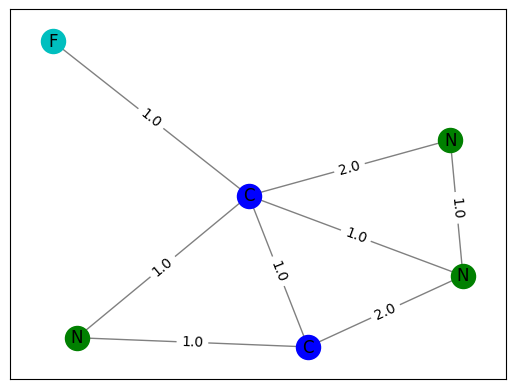

c=0 prediction:  0.9896 c=1 prediction:  0.0104


In [150]:
generate_and_draw_graph(g, candidate_set, max_gen_step=10)

### TEST

In [ ]:
from Load_dataset import load_split_MUTAG_data, accuracy
from Model import GCN
import time

import numpy as np
import torch
import torch.optim as optim
import torch.nn.functional as F

model_path = 'model/gcn_first.pth'

if __name__ == '__main__':
    adj_list, features_list, graph_labels, idx_map, idx_train, idx_val, idx_test = load_split_MUTAG_data()
    model = GCN(nfeat=features_list[0].shape[1],  # nfeat = 7
                nclass=graph_labels.max().item() + 1,  # nclass = 2
                dropout=0.1)

    model.eval()
    outputs = []
    for i in idx_test:
        output = model(features_list[i], adj_list[i])
        output = output.unsqueeze(0)
        outputs.append(output)
    output = torch.cat(outputs, dim=0)

    loss_test = F.cross_entropy(output, graph_labels[idx_test])
    acc_test = accuracy(output, graph_labels[idx_test])
    print(loss_test)
    print(acc_test)

ModuleNotFoundError: No module named 'Load_dataset'